# MTH9899 Machine Learning Homework #1
## Likun Ouyang

### Problem 1
Ignoring more sophisticated algorithms, like the Strassen algorithm, multiplying
an a × b matrix by a b × c matrix takes O(abc). Please work out the time complexity
of computing a naive K-Fold Cross Validation Ridge Regression on an N × F input
matrix.

### Solution 1

The time complexity of solving a linear equation $AX=b$ by Cholesky Decomposition where A is a $n\times n$ matrix is $O(n^3)$.

For solving the beta part, assume the length of lambdas vector is $L$, for each fold and each lambda value, we have to solve the beta and calculate the MSE to find out the optimal lambda. In detail, we have to solve a linear equation and its A is a $F\times F$ matrix, so it costs $O(F^3)$ each time. And we need to loop it for KL times, so totally it costs $O(F^3KL)$.

The matrix multiplication of $X^T$ and $X$ where $X$ is a $N\frac{K-1}{K} \times F$ matrix costs $O(NF^2)$.And we need to loop it through for K times, so totally it costs $O(NF^2K)$.

The matrix multiplication of $X_i$ and $\beta$ costs $O(\frac{NF}{K})$, and we need to loop it for KL times, so totally it costs $O(NFL)$.

All in all, the total time complexity of computing a naive K-Fold Cross Validation Ridge Regression on an $N \times F$ input matrix is $O(max(NF^2K,F^3KL, NFL))$

### Problem 2
We can be more efficient. We don’t have to compute $X^{T}X$
completely each
time. In particular, if you break up $X$ into $K$ chunks, there is a faster way.

$$ X\,=\, \begin{bmatrix} X_1 \\ X_2 \\ \vdots \\ X_K \end{bmatrix}$$

$$ X^{T} X \,=\, \begin{bmatrix} X^{T}_1 & X^{T}_2 & \ldots &  X^{T}_K \end{bmatrix}  \begin{bmatrix} X_1 \\ X_2 \\ \vdots \\ X_K \end{bmatrix} $$

- Define $X_{-i}$ as $X$ with the ith fold omitted. Given these hints, write a description
of how you can efficiently compute $X^{T}_{-i}X_{-i}$
for all $K$ folds.

### Solution 2

Since
$$ 
X^{T} X \,=\, \begin{bmatrix} X^{T}_1 & X^{T}_2 & \ldots &  X^{T}_K \end{bmatrix}  \begin{bmatrix} X_1 \\ X_2 \\ \vdots \\ X_K \end{bmatrix}  = \sum_{j=1}^{K} X_j^T X_j
$$

Then for $X^{T}_{-i}X_{-i}$ for all $K$, we have

$$
X^{T}_{-i}X_{-i} = \sum_{j=1}^{K} X_j^T X_j - X^{T}_{i}X_{i} = X^{T} X - X^{T}_{i}X_{i}
$$

So for each fold, we only need to subtract $X^{T}_{i}X_{i}$ from $X^{T} X$ in order to compute $X^{T}_{-i}X_{-i}$

### Problem 3
Implement the algorithms discussed in a Jupyter Notebook.
- Using what you learned in Problem 2, implement 2 versions of Ridge Regression in
the Python template shown below. One should be the slower naive algorithm, the
other should be the faster version derived in Problem 2. Don’t use any external
math packages (other than NumPy).

- Test them. Generate random datasets with varying numbers of rows (anything
from 1000 rows to 1,000,000) for 5 and 50 columns. Test both algos with 10
reasonable lambda values, and plot the time it takes to compute both versions as
a function of N.

### Solution 3

I work out the algorithm and improved the efficiency of my algorithm after discussion with Junliang Zhou. Discussed topics includes:

- Implementatin of splitting the data set into K-fold

- Choice of lambda values and row numbers N

- Volatile Time Measure 

- and other topics


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
import time

In [9]:
def generate_test_data(n, f):
    """
    A function to generate normally distributed random test data for linear regressions.
    """

    np.random.seed(1)
    true_betas = np.random.randn(f)

    X = np.random.randn(n, f)
    Y = np.random.randn(n) + X.dot(true_betas)

    return X, Y

In [10]:
def naive_ridge_cv(X, Y, num_folds, lambdas):
    '''Implements a naive Ridge Regression o f X against Y. It will take in a list of suggested lambda value s and return back the lambda
    and betas that generates minimum mean squared error.

    Parameters
−−−−−−−−−−
    X : numpy ndarray
    The independent variables , structured as ( samples x features )
    Y : numpy ndarray
    The dependent variable , ( samples x 1 )
    num_folds : int
    The number of folds to use for cross validation
    lambdas : numpy ndarray
    An array of lambda values to test

    Returns
−−−−−−−
    lambda_star : float
    The lambda value that represents the min MSE
    beta_star : numpy ndarray
    The optimal betas
    '''
    N = X.shape[0]
    F = X.shape[1]
    l = int(N / num_folds)
    n_new = l * num_folds
    X = X[:n_new]
    Y = Y[:n_new]

    XTX = np.dot(X.T, X)
    XTY = np.dot(X.T, Y)

    MSEs = np.zeros_like(lambdas)

    X_i = np.split(X, num_folds, 0)
    Y_i = np.split(Y, num_folds)

    # iterate through each fold
    for i in range(num_folds):
        # partition X and Y into K fold and get the train and test set
        X_train = np.vstack(X_i[:i] + X_i[(i + 1):])
        Y_train = np.hstack(Y_i[:i] + Y_i[(i + 1):])
        XTX_k = np.dot(X_train.T, X_train)
        XTY_k = np.dot(X_train.T, Y_train)
        j = 0
        for lambd in lambdas:
            # calculate the beta hat on each fold for each lambda
            beta_hat = np.linalg.solve(XTX_k + lambd * np.identity(n=F), XTY_k)
            # aggregate the MSEs over all folds for each lambda value
            MSEs[j] = MSEs[j] + np.linalg.norm(Y_i[i] -
                                               np.dot(X_i[i], beta_hat))
            j = j + 1
        # print(MSEs)

    MSEs = MSEs / len(lambdas)

    optimal_lambda = lambdas[np.argmin(MSEs)]

    beta_star = np.linalg.solve(XTX + optimal_lambda * np.identity(n=F), XTY)

    return (optimal_lambda, beta_star)

In [11]:
def fast_ridge_cv(X, Y, num_folds, lambdas):
    '''Implements a fast Ridge Regression o f X against Y. It will take in a list of suggested lambda value s and return back the lambda
    and betas that generates minimum mean squared error.
    
    Parameters
−−−−−−−−−−
    X : numpy ndarray
    The independent variables , structured as ( samples x features )
    Y : numpy ndarray
    The dependent variable , ( samples x 1 )
    num_folds : int
    The number of folds to use for cross validation
    lambdas : numpy ndarray
    An array of lambda values to test
    
    Returns
−−−−−−−
    lambda_star : float
    The lambda value that represents the min MSE
    beta_star : numpy ndarray
    The optimal betas
    '''
    N = X.shape[0]
    F = X.shape[1]
    l = int(N / num_folds)
    n_new = l * num_folds
    X = X[:n_new]
    Y = Y[:n_new]

    X_i = np.split(X, num_folds, 0)
    Y_i = np.split(Y, num_folds)

    XTX_set = [np.dot(x.T, x) for x in X_i]
    XTY_set = [np.dot(x.T, y) for x, y in zip(X_i, Y_i)]

    XTX = reduce((lambda x, y: x + y), XTX_set)
    XTY = reduce((lambda x, y: x + y), XTY_set)

    MSEs = np.zeros_like(lambdas)

    for i in range(num_folds):
        j = 0
        XTX_train = XTX - XTX_set[i]
        XTY_train = XTY - XTY_set[i]
        for lambd in lambdas:
            #calculate the beta hat on each fold for each lambda
            beta_hat = np.linalg.solve(XTX_train + lambd * np.identity(n=F),
                                       XTY_train)
            #aggregate the MSEs over all folds for each lambda value
            MSEs[j] = MSEs[j] + np.linalg.norm(Y_i[i] -
                                               np.dot(X_i[i], beta_hat))
            j = j + 1
        #print(MSEs)

    MSEs = MSEs / len(lambdas)

    #get the lambda value that have the lowest average
    optimal_lambda = lambdas[np.argmin(MSEs)]

    beta_star = np.linalg.solve(XTX + optimal_lambda * np.identity(n=F), XTY)

    return (optimal_lambda, beta_star)

In [12]:
X, Y = generate_test_data(10000, 8)
lambdas = [10, 5, 2, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.00001]
optimal_lambda, beta_star = naive_ridge_cv(X, Y, 10, lambdas)
print("the optimal lambda is :", optimal_lambda)
print("the beta_star is :", beta_star)

the optimal lambda is : 1e-05
the beta_star is : [ 1.62608349 -0.61636238 -0.53081473 -1.06968576  0.87021369 -2.30242773
  1.74172319 -0.74887688]


In [13]:
X, Y = generate_test_data(10000, 8)
lambdas = [10, 5, 2, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.00001]
optimal_lambda, beta_star = fast_ridge_cv(X, Y, 10, lambdas)
print("the optimal lambda is :", optimal_lambda)
print("the beta_star is :", beta_star)

the optimal lambda is : 1e-05
the beta_star is : [ 1.62608349 -0.61636238 -0.53081473 -1.06968576  0.87021369 -2.30242773
  1.74172319 -0.74887688]


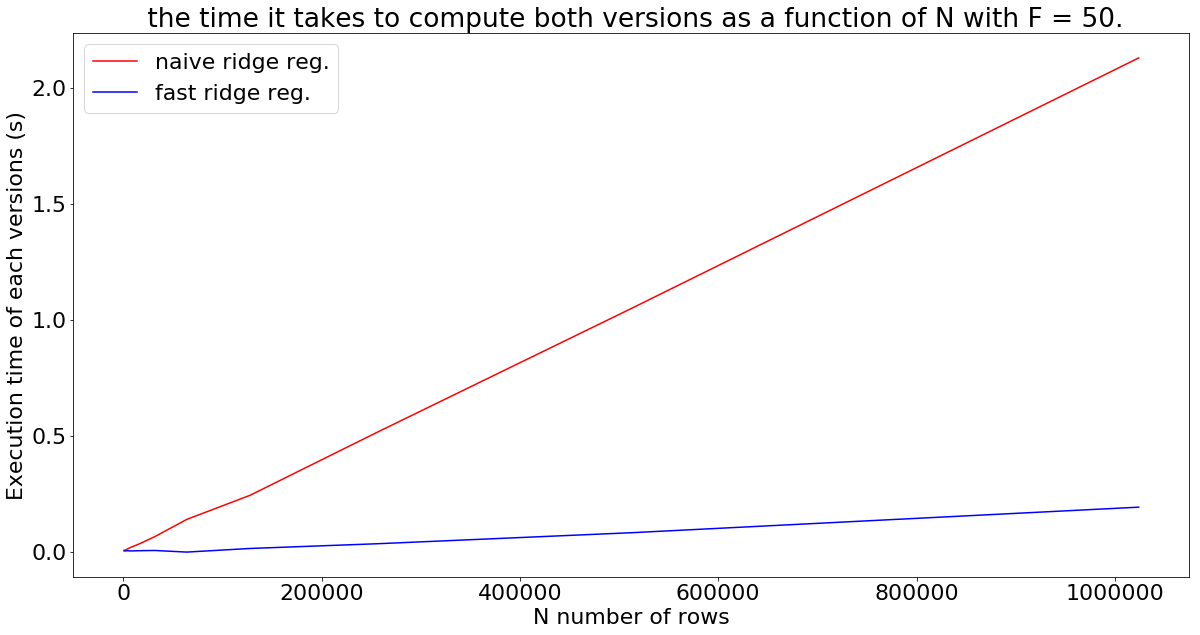

In [14]:
lambdas = [10, 5, 2, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.00001]
row_list = [1000 * 2**i for i in range(0, 11)]
naive_time = []
fast_time = []
for N in row_list:
    X, Y = generate_test_data(N, 50)
    start_time = time.time()
    naive_ridge_cv(X, Y, 10, lambdas)
    naive_time.append(time.time() - start_time)
    start_time = time.time()
    fast_ridge_cv(X, Y, 10, lambdas)
    fast_time.append(time.time() - start_time)

plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 22})
plt.plot(row_list, naive_time, 'r', label="naive ridge reg.")
plt.plot(row_list, fast_time, 'b', label="fast ridge reg.")
plt.title(
    " the time it takes to compute both versions as a function of N with F = 50."
)
plt.legend(loc="upper left")
plt.xlabel("N number of rows")
plt.ylabel("Execution time of each versions (s)")
plt.show()

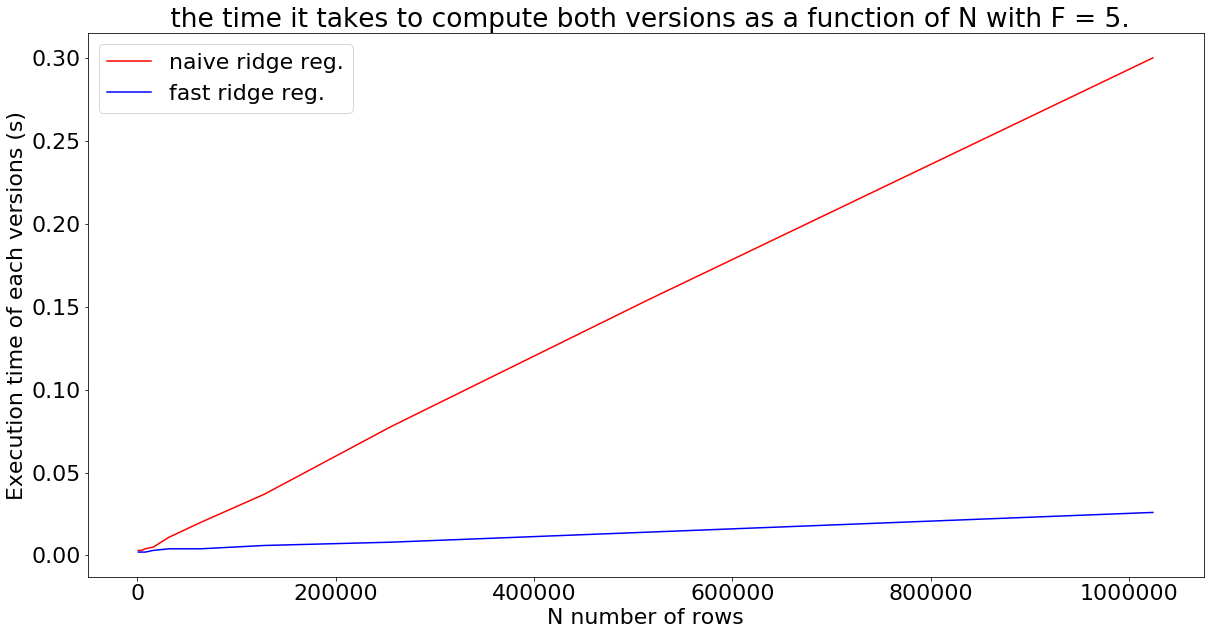

In [15]:
lambdas = [10, 5, 2, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.00001]
row_list = [1000 * 2**i for i in range(0, 11)]
naive_time = []
fast_time = []
for N in row_list:
    X, Y = generate_test_data(N, 5)
    start_time = time.time()
    naive_ridge_cv(X, Y, 10, lambdas)
    naive_time.append(time.time() - start_time)
    start_time = time.time()
    fast_ridge_cv(X, Y, 10, lambdas)
    fast_time.append(time.time() - start_time)

plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 22})
plt.plot(row_list, naive_time, 'r', label="naive ridge reg.")
plt.plot(row_list, fast_time, 'b', label="fast ridge reg.")
plt.title(
    " the time it takes to compute both versions as a function of N with F = 5."
)
plt.legend(loc="upper left")
plt.xlabel("N number of rows")
plt.ylabel("Execution time of each versions (s)")
plt.show()

In [16]:
%prun fast_ridge_cv(X,Y,10,lambdas)